In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
!pip install split-folders

In [85]:
!pip install torchsummary

In [104]:
import os
import zipfile
import numpy as np
import cv2
import random
import collections
import splitfolders
from glob import glob
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from time import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

In [67]:
print(os.getcwd())
print(os.listdir())

/content
['.config', 'drive', 'sample_data']


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
path_to_zipfile = '/content/drive/MyDrive/archive.zip'
directory_to_extract = '/content/drive/MyDrive'

with zipfile.ZipFile(path_to_zipfile, 'r') as zip_ref:
  zip_ref.extractall(directory_to_extract)

In [61]:
def plot_three_samples(letter):
    print("Samples images for letter", letter)
    path = 'drive/MyDrive/asl_alphabet_train/asl_alphabet_train/'
    img_path = path + letter + '/**'
    path_contents = glob(img_path)
    
    plt.figure(figsize=(16,16))
    imgs = random.sample(path_contents, 3)
    plt.subplot(131)
    plt.imshow(cv2.imread(imgs[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(imgs[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(imgs[2]))
    return

Samples images for letter A


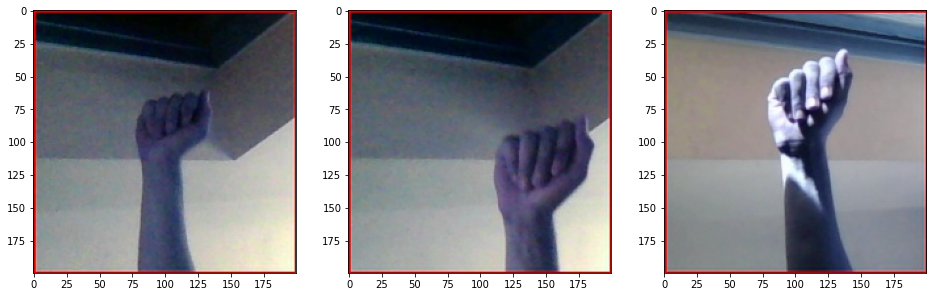

In [62]:
plot_three_samples('A')

In [68]:
splitfolders.ratio('/content/drive/MyDrive/asl_alphabet_train/asl_alphabet_train', output='/content/drive/MyDrive/asl_alphabet_dataset', seed=1337, ratio=(0.8,0.1,0.1))

Copying files: 87000 files [16:33, 87.56 files/s]


In [69]:
train_data_path = '/content/drive/MyDrive/asl_alphabet_dataset/train'
test_data_path = '/content/drive/MyDrive/asl_alphabet_dataset/test'
val_data_path = '/content/drive/MyDrive/asl_alphabet_dataset/val'

data_transformer = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.ImageFolder(train_data_path, transform=data_transformer)
test_dataset = datasets.ImageFolder(test_data_path, transform=data_transformer)
val_dataset = datasets.ImageFolder(val_data_path, transform=data_transformer)

print(train_dataset)
print(test_dataset)
print(val_dataset)

Dataset ImageFolder
    Number of datapoints: 69600
    Root location: /content/drive/MyDrive/asl_alphabet_dataset/train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 8700
    Root location: /content/drive/MyDrive/asl_alphabet_dataset/test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 8700
    Root location: /content/drive/MyDrive/asl_alphabet_dataset/val
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [71]:
print(dict(collections.Counter(train_dataset.targets)))
print(dict(collections.Counter(test_dataset.targets)))
print(dict(collections.Counter(val_dataset.targets)))


{0: 2400, 1: 2400, 2: 2400, 3: 2400, 4: 2400, 5: 2400, 6: 2400, 7: 2400, 8: 2400, 9: 2400, 10: 2400, 11: 2400, 12: 2400, 13: 2400, 14: 2400, 15: 2400, 16: 2400, 17: 2400, 18: 2400, 19: 2400, 20: 2400, 21: 2400, 22: 2400, 23: 2400, 24: 2400, 25: 2400, 26: 2400, 27: 2400, 28: 2400}
{0: 300, 1: 300, 2: 300, 3: 300, 4: 300, 5: 300, 6: 300, 7: 300, 8: 300, 9: 300, 10: 300, 11: 300, 12: 300, 13: 300, 14: 300, 15: 300, 16: 300, 17: 300, 18: 300, 19: 300, 20: 300, 21: 300, 22: 300, 23: 300, 24: 300, 25: 300, 26: 300, 27: 300, 28: 300}
{0: 300, 1: 300, 2: 300, 3: 300, 4: 300, 5: 300, 6: 300, 7: 300, 8: 300, 9: 300, 10: 300, 11: 300, 12: 300, 13: 300, 14: 300, 15: 300, 16: 300, 17: 300, 18: 300, 19: 300, 20: 300, 21: 300, 22: 300, 23: 300, 24: 300, 25: 300, 26: 300, 27: 300, 28: 300}


In [73]:
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_dataset]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_dataset]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])


val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in val_dataset]
val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in val_dataset]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])
val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])


test_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in test_dataset]
test_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in test_dataset]

test_meanR = np.mean([m[0] for m in test_meanRGB])
test_meanG = np.mean([m[1] for m in test_meanRGB])
test_meanB = np.mean([m[2] for m in test_meanRGB])
test_stdR = np.mean([s[0] for s in test_stdRGB])
test_stdG = np.mean([s[1] for s in test_stdRGB])
test_stdB = np.mean([s[2] for s in test_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)
print(test_meanR, test_meanG, test_meanB)

0.5195615 0.49977392 0.5145552
0.5190376 0.49879244 0.5135289
0.5146701 0.4950814 0.5097887


In [83]:
train_transformer = transforms.Compose([transforms.Resize(256), transforms.RandomCrop(224),transforms.ToTensor(),
                                        transforms.Normalize([train_meanR, train_meanG,train_meanB],[train_stdR, train_stdG, train_stdB])])
val_transformer = transforms.Compose([transforms.Resize(256), transforms.RandomCrop(224),transforms.ToTensor(),
                                        transforms.Normalize([val_meanR, val_meanG,val_meanB],[val_stdR, val_stdG, val_stdB])])
test_transformer = transforms.Compose([transforms.Resize(256), transforms.RandomCrop(224),transforms.ToTensor(),
                                        transforms.Normalize([test_meanR, test_meanG,test_meanB],[test_stdR, test_stdG, test_stdB])])

train_dataset = datasets.ImageFolder(train_data_path, transform=train_transformer)
test_dataset = datasets.ImageFolder(test_data_path, transform=test_transformer)
val_dataset = datasets.ImageFolder(val_data_path, transform=val_transformer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

In [98]:
resnet_18 = models.resnet18(pretrained=True)
resnet_50 = models.resnet50(pretrained=True)

print('***************************Resnet 18***************************')
summary(resnet_18,(3,224,224))

print('\n'+'***************************Resnet 50***************************')
summary(resnet_50,(3,224,224))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

***************************Resnet 18***************************
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64,

In [102]:
for param in resnet_18.parameters():
  param.requires_grad = False

for param in resnet_50.parameters():
  param.requires_grad = False

resnet18_in_features = resnet_18.fc.in_features
resnet50_in_featuers = resnet_50.fc.in_features

new_resnet18_fc = torch.nn.Sequential(nn.Linear(in_features=resnet18_in_features, out_features=29, bias=True))
new_resnet50_fc = torch.nn.Sequential(nn.Linear(in_features=resnet50_in_featuers, out_features=1000, bias=True), nn.ReLU(inplace=True), nn.Linear(in_features=1000, out_features=29, bias=True))

resnet_18.fc = new_resnet18_fc
resnet_50.fc = new_resnet50_fc

criterion = nn.CrossEntropyLoss()
resnet18_optimizer = optim.Adam(resnet_18.parameters(), lr = 0.001)
resnet50_optimizer = optim.Adam(resnet_50.parameters(), lr = 0.001)


In [103]:
summary(resnet_18,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
r18_print_every = 1000
r18_steps = 0
r18_train_losses, r18_val_losses = [], []

resnet_18.to(device)
for epoch in tqdm(range(10)):
    r18_iterations = 0
    r18_running_loss = 0
    r18_correct_train = 0
    r18_total_train = 0
    r18_start_time = time()
    
    resnet_18.train()
    for i, (images, labels) in enumerate(train_loader):
        r18_steps += 1
        images = images.to(device)
        labels = labels.to(device)
            
        # Forward pass
        output = resnet_18(images)
        r18_loss = criterion(output, labels)
    
        r18_correct_train += (torch.max(output, dim=1)[1] == labels).sum()
        r18_total_train += labels.size(0)
        
        # Backward and optimize
        resnet18_optimizer.zero_grad()
        r18_loss.backward()
        resnet18_optimizer.step()
        
        r18_iterations += 1
        r18_running_loss += loss.item()
        
        if r18_steps % r18_print_every == 0:
            print(f'Epoch [{epoch + 1}]/[{10}]. Batch [{i + 1}]/[{len(train_loader)}]. Train loss {r18_running_loss / r18_steps}.', end=' ')
            print(f'Train acc {r18_correct_train / r18_total_train * 100}.', end=' ')
            with torch.no_grad():
                resnet_18.eval()
                r18_correct_val, r18_total_val = 0, 0
                r18_val_loss = 0
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    output = resnet_18(images)
                    r18_loss = criterion(output, labels)
                    val_loss += r18_loss.item()

                    r18_correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                    r18_total_val += labels.size(0)

            print(f'Val loss {r18_val_loss / len(val_loader)}. Val acc {r18_correct_val / r18_total_val * 100}')

            train_losses.append(r18_running_loss / r18_total_train)
            val_losses.append(r18_val_loss / r18_total_val)
        
        
    print(f'Epoch took {time() - start_time}') 
    torch.save(resnet_18, f'checkpoint_{r18_correct_val / r18_total_val * 100:.2f}')

    #https://www.kaggle.com/julichitai/asl-alphabet-classification-using-pytorch

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
plt.plot(r18_train_losses, label='Training loss')
plt.plot(r18_val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
with torch.no_grad():
  resnet_18.eval()
  r18_correct_test, r18_total_test = 0, 0
  r18_test_loss = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    output = resnet_18(images)
    r18_test_loss = criterion(output, labels)
    test_loss += r18_test_loss.item()

  r18_correct_test += (torch.max(output, dim=1)[1] == labels).sum()
  r18_total_test += labels.size(0)

print(f'Test loss {r18_test_loss / len(test_loader)}. Test acc {r18_correct_test / r18_total_test * 100}')

In [ ]:
r50_print_every = 1000
r50_steps = 0
r50_train_losses, r50_val_losses = [], []

resnet_50.to(device)
for epoch in tqdm(range(10)):
    r50_iterations = 0
    r50_running_loss = 0
    r50_correct_train = 0
    r50_total_train = 0
    r50_start_time = time()
    
    resnet_50.train()
    for i, (images, labels) in enumerate(train_loader):
        r50_steps += 1
        images = images.to(device)
        labels = labels.to(device)
            
        # Forward pass
        output = resnet_50(images)
        r50_loss = criterion(output, labels)
    
        r50_correct_train += (torch.max(output, dim=1)[1] == labels).sum()
        r50_total_train += labels.size(0)
        
        # Backward and optimize
        resnet50_optimizer.zero_grad()
        r50_loss.backward()
        resnet50_optimizer.step()
        
        r50_iterations += 1
        r50_running_loss += loss.item()
        
        if r50_steps % r50_print_every == 0:
            print(f'Epoch [{epoch + 1}]/[{10}]. Batch [{i + 1}]/[{len(train_loader)}]. Train loss {r50_running_loss / r50_steps}.', end=' ')
            print(f'Train acc {r50_correct_train / r50_total_train * 100}.', end=' ')
            with torch.no_grad():
                resnet_50.eval()
                r50_correct_val, r50_total_val = 0, 0
                r50_val_loss = 0
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    output = resnet_50(images)
                    r50_loss = criterion(output, labels)
                    val_loss += r50_loss.item()

                    r50_correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                    r50_total_val += labels.size(0)

            print(f'Val loss {r50_val_loss / len(val_loader)}. Val acc {r50_correct_val / r50_total_val * 100}')

            train_losses.append(r50_running_loss / r50_total_train)
            val_losses.append(r50_val_loss / r50_total_val)
        
        
    print(f'Epoch took {time() - start_time}') 
    torch.save(resnet_50, f'checkpoint_{r50_correct_val / r50_total_val * 100:.2f}')

In [ ]:
plt.plot(r50_train_losses, label='Training loss')
plt.plot(r50_val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
with torch.no_grad():
  resnet_50.eval()
  r50_correct_test, r50_total_test = 0, 0
  r50_test_loss = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    output = resnet_50(images)
    r50_test_loss = criterion(output, labels)
    test_loss += r50_test_loss.item()

  r50_correct_test += (torch.max(output, dim=1)[1] == labels).sum()
  r50_total_test += labels.size(0)

print(f'Test loss {r50_test_loss / len(test_loader)}. Test acc {r50_correct_test / r50_total_test * 100}')

In [ ]:
#https://deep-learning-study.tistory.com/534